In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras import layers
from keras.layers import Conv1D, GRU, Dense, BatchNormalization, Dropout, MaxPool1D,Activation, regularizers
from keras import Sequential
from keras.preprocessing import text
from keras.layers import regularizers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import scipy.io.wavfile as wav

from sklearn.preprocessing import LabelEncoder

import shutil
import os
from pathlib import Path 
import re
from collections import OrderedDict

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction as aF


from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

Using TensorFlow backend.
C:\Users\vidhy\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
path_data = Path('../data/')
os.listdir(path_data)

['ComParE2018_AtypicalAffect.txt',
 'readme.docx',
 'Schuller_SpeechAnalysis.pdf',
 'spectogram',
 'wav']

In [6]:
df_labs = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep='\t')

def getData(file):
    [fs,x]  = audioBasicIO.readAudioFile(path_data/'wav'/file)
    x = np.resize(x,(fs*4,))
    [s,t] = aF.stFeatureExtraction(x,fs,0.050*fs,0.025*fs)
    s = s.T
    return s

def fetch_data(directory='wav/', subset='train'):
    sub = df_labs['file_name'].apply(lambda fn: subset in fn)
    df_lab_sub = df_labs[sub]
    y = df_lab_sub['emotion'].values
    fn = df_lab_sub['file_name']

    X = OrderedDict()
    for f in fn:
        X[f] = getData(f)
        
    return X.values(), y

In [7]:
(tr_X, tr_y) = fetch_data(directory=path_data/'wav', subset='train')
(dv_X, dv_y) = fetch_data(directory=path_data/'wav', subset='devel')
(test_X, test_y) = fetch_data(directory=path_data/'wav', subset='test')

In [8]:
tr_X = np.asarray(list(tr_X))
dv_X = np.asarray(list(dv_X))
test_X = np.asarray(list(test_X))

In [9]:
def normalize_data(tr_X, val_X = None, ts_X=None):
    m = tr_X.mean()
    sd = tr_X.std()
    return (tr_X-m)/sd #, (val_X-m)/sd, (ts_X-m)/sd, 

tr_X = normalize_data(tr_X)
dv_X = normalize_data(dv_X)
test_X = normalize_data(test_X)

In [10]:
le = LabelEncoder()
tr_y = le.fit_transform(tr_y)

le = LabelEncoder()
dv_y = le.fit_transform(dv_y)

le = LabelEncoder()
test_y = le.fit_transform(test_y)

In [11]:
from collections import Counter
c = Counter(tr_y)
len(tr_y)/np.asarray(list(c.values())) #class weights based on number of samples

array([ 1.46130302,  4.49798116, 17.87165775, 26.736     ])

In [35]:
class_weight = {0: 23.736,
                1: 4.49798116,
                2: 1.46130302,
                3: 17.87165775}

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [36]:
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=10, activation='relu', input_shape=(np.shape(tr_X)[1], np.shape(tr_X)[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.1))

model.add(layers.Flatten())
model.add(Dense(4, activation='sigmoid'))
model.compile(optimizer=RMSprop(lr=.0001), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 150, 15)           5115      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 15)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 69, 32)            3392      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 32)            5152      
__________

In [37]:
model.fit(tr_X, tr_y, epochs=100,validation_data=(dv_X, dv_y),class_weight=class_weight, callbacks=[es],verbose=0 )

Epoch 00027: early stopping


In [38]:
y_pred = model.predict(dv_X)
y_pred = y_pred.argmax(axis = 1)

In [39]:
def reporting(y_test,y_pred):
    confusion_matrix = ConfusionMatrix(y_test, y_pred)
    confusion_matrix.plot()
    plt.show()
    print(confusion_matrix)
    print("\n",classification_report(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))

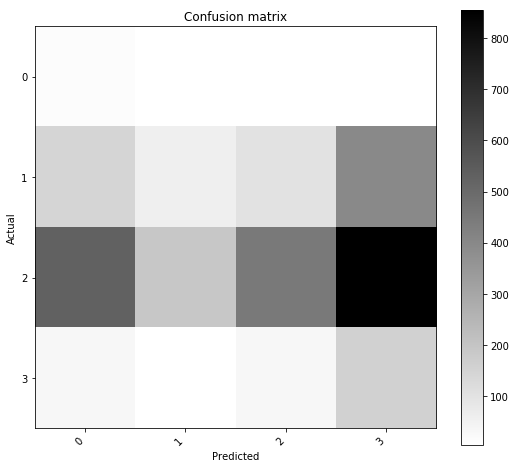

Predicted    0    1    2     3  __all__
Actual                                 
0           17    6    5     5       33
1          146   61  103   399      709
2          530  191  448   855     2024
3           33    8   34   159      234
__all__    726  266  590  1418     3000

               precision    recall  f1-score   support

           0       0.02      0.52      0.04        33
           1       0.23      0.09      0.13       709
           2       0.76      0.22      0.34      2024
           3       0.11      0.68      0.19       234

   micro avg       0.23      0.23      0.23      3000
   macro avg       0.28      0.38      0.18      3000
weighted avg       0.58      0.23      0.28      3000

0.22833333333333333


In [40]:
reporting(dv_y,y_pred) #on validation set

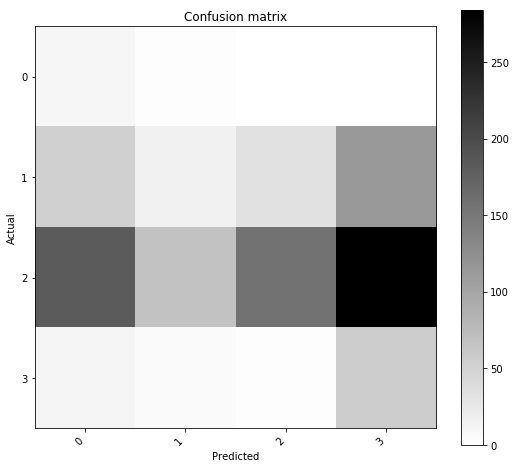

Predicted    0   1    2    3  __all__
Actual                               
0           10   3    0    1       14
1           53  16   34  114      217
2          183  68  156  284      691
3           12   6    3   56       77
__all__    258  93  193  455      999

               precision    recall  f1-score   support

           0       0.04      0.71      0.07        14
           1       0.17      0.07      0.10       217
           2       0.81      0.23      0.35       691
           3       0.12      0.73      0.21        77

   micro avg       0.24      0.24      0.24       999
   macro avg       0.29      0.44      0.19       999
weighted avg       0.61      0.24      0.28       999

0.23823823823823823


In [41]:
#test prediction 
y_pred_t = model.predict(test_X)
y_pred_t = y_pred_t.argmax(axis = 1)
reporting(test_y,y_pred_t)